In [1]:
from generate_data import Data
from evaluate import *
from models import *

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
%autosave 120

Autosaving every 120 seconds


# Get the synthetic dataset

In [4]:
%%time
data = Data(layer_size=16)

C:\Users\franm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


CPU times: total: 688 ms
Wall time: 705 ms


In [5]:
%%time
train, val, test = data.get_splits(['random_subsample'], [[0.05, 0.95]])

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)

Number of samples: 198 train | 754 val | 3017 test
CPU times: total: 297 ms
Wall time: 306 ms


#### Peek at unshuffled train data

In [6]:
train_original[:20]

[[',,..,__._,.,._.,', '______.,_.uw._.,', '___..,__.__dr_._', True],
 [',___,,._,,.__.,.', '__._,__w__._,,,,', '_,.,,,.,_.dr_...', True],
 [',...__..,.,,,_..', '.,___.__.wu___.,', '._cr._..__,,,.,.', False],
 ['.,,._.._.,_,,,..', '_..__,,,.,.__.,,', ',_,._._,_,.r,,__', True],
 ['.__.,,.,,_.,___,', '_._,,,._..._,_,,', '._.,_dr.,,.._,__', True],
 [',,__,,_.___...,_', '_,__,_,_,,_._..,', '_,.,,cr.._,.._,.', False],
 ['.._...,.,._,,.,,', ',._,,.,,,.w_._.,', ',,.,,__.,.__,__,', False],
 ['._.,..._.._...._', '_,_...__.,,.wu,_', '_.._.,.._._,_,._', False],
 ['.._._,,_._,....,', '_....__,.,uw,_._', ',.,_,,.._,__r,,,', True],
 ['.,_..,,._,__.,,.', ',___,_.._,_,w.,_', ',,._,,..__,cr__.', False],
 [',..._.____.__,_,', '.,,,_wu_...,_,_,', '_..__,.__,.r....', True],
 [',,.,_,__.,.__.,_', '...,__.,.__._..,', '_,_....,,.cr,__,', False],
 ['._._..,,_,...._.', '_._._,wu_.,___..', '__,.._,_.,.,....', False],
 [',__,,_._.,.,.,,.', 'w._.,,_.._,_..._', '_...__.__..._._.', False],
 ['.,._.,._.,,__,..', '__.

In [7]:
pos_train_ratio = get_stats_and_ratio(train_original)

Number of samples by case:
F3 dr:    F2-wu 16 | F2-uw 14 | F2-w 14 | F2-noop 12 | 
F3 cr:    F2-wu 12 | F2-uw 12 | F2-w 11 | F2-noop 12 | 
F3 r:    F2-wu 11 | F2-uw 10 | F2-w 13 | F2-noop 14 | 
F3 noop:    F2-wu 11 | F2-uw 13 | F2-w 13 | F2-noop 10 | 

Positive samples count: 88
Total samples count: 198
Positive class ratio: 0.4444444444444444


#### Peek at test data

In [8]:
test_original[:15]

[['_,,.,..._,._.___', ',._wu.,.,,.__.,_', '__._,,_..r.,,,.,', True],
 ['_,_.,_,__,,.._,.', ',.,,.,,,wu_.,...', '.,_._,__._,__.._', False],
 ['..,,,,.__._.,.._', 'wu,..,..,..__,,.', 'cr.,._.....,._._', False],
 [',,__.,_,_.._._,_', ',_,,._.w,___.,_,', ',,,_,,r_,...,,,_', True],
 ['.__,_,_._,.,..,,', ',...._...uw_,__,', '._,r,_,.._,,_.,_', True],
 [',..,_,,..,_,__..', '..__,,,.,._.,._,', '_.,._,..cr_..._.', False],
 [',,_,.,_,._.___,_', 'w,,,.._..._,_,,_', '._.,._.,._.__.__', False],
 ['._..,_.__.,,.,..', '._._,.._,,_,.wu,', 'cr,_,,.___.,__..', False],
 ['_,.._..,,.,_,_,.', '.,_.,_,wu__,.___', 'dr_,.__,_,._,,_.', False],
 ['___,___,,,_,_.,.', '_.____.._,,.,.__', '..._..r,._,.,_,.', True],
 ['_,..,_,_,.,,,.,.', '_,__.._.,,.wu,._', ',...,.._.,_...,_', False],
 ['._,._.___,,,._..', ',,____,,._,___,.', ',.._,,.,.,_,.,_.', False],
 ['_..._,,,.,,,,,.,', '_.._.,_w,,___,_,', '_,_,,_.,..._.,,.', False],
 ['__..,_._,._._..,', ',.,_.,uw._._,...', ',r__,__,.,,.,__,', True],
 ['._._.._.__,..,,,', '_,

In [9]:
pos_test_ratio = get_stats_and_ratio(test_original)

Number of samples by case:
F3 dr:    F2-wu 176 | F2-uw 170 | F2-w 184 | F2-noop 190 | 
F3 cr:    F2-wu 171 | F2-uw 176 | F2-w 173 | F2-noop 194 | 
F3 r:    F2-wu 171 | F2-uw 187 | F2-w 199 | F2-noop 205 | 
F3 noop:    F2-wu 200 | F2-uw 183 | F2-w 211 | F2-noop 227 | 

Positive samples count: 1306
Total samples count: 3017
Positive class ratio: 0.43288034471329134


#### Peek at val data

In [10]:
val_original[:15]

[['__..__._,__,,___', '.,__.__,.,uw_,.,', '..__,,__.,_...,_', False],
 ['.,__,_.,__,_,._.', ',,,,,...._,w,,_,', '..,_.,,._r_.__,.', True],
 ['_,__._._,_,,....', '.,wu_,_,_,.___,.', '_.,.,,_.r,,,.,,_', True],
 ['._...,,._.._,.,,', ',.,_._._..uw.,.,', ',,,_.,,,__,,,_,,', False],
 ['__,_,..,..._,,_.', '.,_,_._.._uw_,..', ',_r,,._,..,.__.,', True],
 [',,_,_.._,.__._,.', '_w.._..._,_...,,', ',,..,_,.__.,.r..', True],
 [',____.,_,_......', '.__..wu._,..._.,', '_.._,,.__,_..dr,', False],
 ['.,.._,_,.._,._..', '_wu,...,.,,.__,.', ',,_,..,....,cr__', False],
 ['.,_,_..,,_..,...', ',._,....__,_.__,', '_,._,,_,r.,,_.,.', True],
 ['.__,.._,,.____..', '._,wu,____..__..', ',,_.,_,..,.cr_.,', False],
 [',_.__,_,,.,__.,_', ',.___,,,.,_.,,..', '___,_._.__.,._.,', False],
 ['._.,,._,_,.,_,..', '..._.,._.,._,,_,', '._.,.,,____.,_._', False],
 [',_,_.,.._._.._.,', '___..,,,,,uw,_,_', '_._,,,__.,___,,.', False],
 ['_...,..,_,._,._.', ',,,_._.._.,,._wu', '..__.,,_..,_,_..', False],
 ['..,,___..,,..__.', ',_

In [11]:
pos_val_ratio = get_stats_and_ratio(val_original)

Number of samples by case:
F3 dr:    F2-wu 33 | F2-uw 41 | F2-w 42 | F2-noop 53 | 
F3 cr:    F2-wu 42 | F2-uw 37 | F2-w 56 | F2-noop 49 | 
F3 r:    F2-wu 58 | F2-uw 43 | F2-w 44 | F2-noop 53 | 
F3 noop:    F2-wu 44 | F2-uw 59 | F2-w 48 | F2-noop 52 | 

Positive samples count: 334
Total samples count: 754
Positive class ratio: 0.44297082228116713


#### Send label arrays to device

In [12]:
y_train = torch.from_numpy(y_train.astype(float)).float().to(device)
y_val = torch.from_numpy(y_val.astype(float)).float().to(device)
y_test = torch.from_numpy(y_test.astype(float)).float().to(device)

#### Get data in normal format (same as CNN format)

In [13]:
x_train_normal = data.to_conv_format(x_train)
x_val_normal = data.to_conv_format(x_val)
x_test_normal = data.to_conv_format(x_test)
for i in range(len(x_train_normal)):
    x_train_normal[i] = x_train_normal[i].to(device)
    x_val_normal[i] = x_val_normal[i].to(device)
    x_test_normal[i] = x_test_normal[i].to(device)

In [14]:
x_train_normal[0].shape

torch.Size([198, 128])

#### Get data in convolutional format, send to device

In [15]:
x_train_cnn = data.to_conv_format(x_train)
x_val_cnn = data.to_conv_format(x_val)
x_test_cnn = data.to_conv_format(x_test)
for i in range(len(x_train_cnn)):
    x_train_cnn[i] = x_train_cnn[i].to(device)
    x_val_cnn[i] = x_val_cnn[i].to(device)
    x_test_cnn[i] = x_test_cnn[i].to(device)

In [16]:
x_train_cnn[0].shape

torch.Size([198, 128])

#### Get data in LSTM format, send to device

In [17]:
x_train_lstm = data.to_lstm_format(x_train)
x_val_lstm = data.to_lstm_format(x_val)
x_test_lstm = data.to_lstm_format(x_test)
for i in range(len(x_train_lstm)):
    x_train_lstm[i] = x_train_lstm[i].to(device)
    x_val_lstm[i] = x_val_lstm[i].to(device)
    x_test_lstm[i] = x_test_lstm[i].to(device)

In [18]:
x_train_lstm[0].shape

torch.Size([198, 16, 8])

### Define training parameters

In [19]:
num_experiments = 20
epochs = 200
early_stopping_limit = 100

experiment_name = "5%"

### Define training procedure for each model

In [21]:
def train_models(constructor, x_train, x_val, x_test, weight_decay, *argv):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    wrong_preds = []
    best_accuracy = 0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for i in range(num_experiments):
        model = constructor(*argv)
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

        train_losses.append([])
        val_losses.append([])
        train_accs.append([])
        val_accs.append([])
        
        best_acc = 0

        early_stopping_cnt = 0

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = train_epoch(model, x_train, y_train, criterion, optimizer, epoch, 10, verbose=False)
            val_loss, val_acc = eval_epoch(model, x_val, y_val, criterion, 'Validation', verbose=False)

            
            train_losses[-1].append(train_loss)
            val_losses[-1].append(val_loss)
            train_accs[-1].append(train_acc)
            val_accs[-1].append(val_acc)
            
            model_name = constructor.__name__[:constructor.__name__.find('_')]
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f'./temp/{model_name}_model_TEMP_' + experiment_name)    
                early_stopping_cnt = 0
            else:
                early_stopping_cnt += 1

            if early_stopping_cnt >= early_stopping_limit:
                break


        model.load_state_dict(torch.load(f'./temp/{model_name}_model_TEMP_' + experiment_name))
    
        accuracies.append(get_accuracy_by_cases(model, x_test, y_test, test_original))
        precisions.append(get_precision(model, x_test, y_test, test_original))
        recalls.append(get_recall(model, x_test, y_test, test_original))
        f1_scores.append(get_f1(precisions[-1], recalls[-1]))
        
        wrong_preds.append((f"Experimento {i}", get_wrong_predictions(model, x_test, y_test, test_original)))

        if accuracies[-1]['Overall'] > best_accuracy:
            torch.save(model.state_dict(), f'./bestmodels/best_{model_name}_model_' + experiment_name)    
            best_accuracy = accuracies[-1]['Overall']

        print(i + 1, "/", num_experiments, "models trained | Current model test accuracy:", accuracies[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test precision:", precisions[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test recall:", recalls[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test f1:", f1_scores[-1]['Overall'])


    
    return accuracies, precisions, recalls, f1_scores, wrong_preds, [train_losses, val_losses, train_accs, val_accs], model
    #return accuracies, precisions, wrong_preds, [train_losses, val_losses, train_accs, val_accs]

# Train models

In [22]:
%%time
cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1, cnn_wrong_preds, cnn_epoch_stats, model = train_models(
    CNN_Model, x_train_cnn, x_val_cnn, x_test_cnn, 0.0001, data, 64, 128, 4, -1, 'keras')

C:\Users\franm\AppData\Local\Temp\ipykernel_21588\1162859194.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.9403380841895923
1 / 20 models trained | Current model test precision: 0.8793800539083558
1 / 20 models trained | Current model test recall: 0.9992343032159265
1 / 20 models trained | Current model test f1: 0.935483870967742
2 / 20 models trained | Current model test accuracy: 0.9370235333112363
2 / 20 models trained | Current model test precision: 0.8734939759036144
2 / 20 models trained | Current model test recall: 0.9992343032159265
2 / 20 models trained | Current model test f1: 0.9321428571428572
3 / 20 models trained | Current model test accuracy: 0.9436526350679483
3 / 20 models trained | Current model test precision: 0.8917241379310344
3 / 20 models trained | Current model test recall: 0.9900459418070444
3 / 20 models trained | Current model test f1: 0.9383164005805515
4 / 20 models trained | Current model test accuracy: 0.9406695392774279
4 / 20 models trained | Current model test precision: 0.881000676132522
4 / 20 models 

In [23]:
%%time
lstm_accuracies, lstm_precision, lstm_recall, lstm_f1, lstm_wrong_preds, lstm_epoch_stats, model = train_models(LSTM_Model, x_train_lstm, x_val_lstm, x_test_lstm, 0.0001, data, 16, 32, 8, 'keras')

C:\Users\franm\AppData\Local\Temp\ipykernel_21588\1162859194.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.7265495525356315
1 / 20 models trained | Current model test precision: 0.9743589743589743
1 / 20 models trained | Current model test recall: 0.3782542113323124
1 / 20 models trained | Current model test f1: 0.5449531163816879
2 / 20 models trained | Current model test accuracy: 0.9396751740139211
2 / 20 models trained | Current model test precision: 0.8776881720430108
2 / 20 models trained | Current model test recall: 1.0
2 / 20 models trained | Current model test f1: 0.9348604151753758
3 / 20 models trained | Current model test accuracy: 0.5641365594961882
3 / 20 models trained | Current model test precision: 0.4982830980541778
3 / 20 models trained | Current model test recall: 1.0
3 / 20 models trained | Current model test f1: 0.6651387827858416
4 / 20 models trained | Current model test accuracy: 0.8670865097779251
4 / 20 models trained | Current model test precision: 0.9363548698167792
4 / 20 models trained | Current model test

In [24]:
%%time
deepset_accuracies, deepset_procision, deepset_recall, deepset_f1, deepset_wrong_preds, deepset_epoch_stats, model = train_models(DEEPSET_Model, x_train_normal, x_val_normal, x_test_normal, 0.005, data, 128, 32, 8, 'keras')

C:\Users\franm\AppData\Local\Temp\ipykernel_21588\1162859194.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.5747431223069274
1 / 20 models trained | Current model test precision: 0.5219047619047619
1 / 20 models trained | Current model test recall: 0.20980091883614088
1 / 20 models trained | Current model test f1: 0.2992900054614964
2 / 20 models trained | Current model test accuracy: 0.5744116672190918
2 / 20 models trained | Current model test precision: 0.513189448441247
2 / 20 models trained | Current model test recall: 0.327718223583461
2 / 20 models trained | Current model test f1: 0.4
3 / 20 models trained | Current model test accuracy: 0.6191581040768975
3 / 20 models trained | Current model test precision: 0.6068027210884354
3 / 20 models trained | Current model test recall: 0.34150076569678406
3 / 20 models trained | Current model test f1: 0.4370406663400294
4 / 20 models trained | Current model test accuracy: 0.571760026516407
4 / 20 models trained | Current model test precision: 0.5068359375
4 / 20 models trained | Current mo

In [25]:
%%time
deepsetv2_accuracies, deepsetv2_procision, deepsetv2_recall, deepsetv2_f1, deepsetv2_wrong_preds, deepsetv2_epoch_stats, model = train_models(DEEPSETV2_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 32, 8, 'keras')

C:\Users\franm\AppData\Local\Temp\ipykernel_21588\1162859194.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.43288034471329134
1 / 20 models trained | Current model test precision: 0.43288034471329134
1 / 20 models trained | Current model test recall: 1.0
1 / 20 models trained | Current model test f1: 0.6042100393245431
2 / 20 models trained | Current model test accuracy: 0.43288034471329134
2 / 20 models trained | Current model test precision: 0.43288034471329134
2 / 20 models trained | Current model test recall: 1.0
2 / 20 models trained | Current model test f1: 0.6042100393245431
3 / 20 models trained | Current model test accuracy: 0.43288034471329134
3 / 20 models trained | Current model test precision: 0.43288034471329134
3 / 20 models trained | Current model test recall: 1.0
3 / 20 models trained | Current model test f1: 0.6042100393245431
4 / 20 models trained | Current model test accuracy: 0.43288034471329134
4 / 20 models trained | Current model test precision: 0.43288034471329134
4 / 20 models trained | Current model test recall

In [26]:
%%time
feedforward_accuracies, feedforward_precision, feedforward_recall, feedforward_f1, feedforward_wrong_preds, feedforward_epoch_stats, model = train_models(FEEDFORWARD_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

C:\Users\franm\AppData\Local\Temp\ipykernel_21588\1162859194.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.6092144514418296
1 / 20 models trained | Current model test precision: 0.5509222133119487
1 / 20 models trained | Current model test recall: 0.5260336906584993
1 / 20 models trained | Current model test f1: 0.5381903642773208
2 / 20 models trained | Current model test accuracy: 0.6228041100430891
2 / 20 models trained | Current model test precision: 0.5873180873180873
2 / 20 models trained | Current model test recall: 0.4326186830015314
2 / 20 models trained | Current model test f1: 0.4982363315696649
3 / 20 models trained | Current model test accuracy: 0.6194895591647331
3 / 20 models trained | Current model test precision: 0.5682210708117443
3 / 20 models trained | Current model test recall: 0.5038284839203675
3 / 20 models trained | Current model test f1: 0.5340909090909091
4 / 20 models trained | Current model test accuracy: 0.5989393437189261
4 / 20 models trained | Current model test precision: 0.5674157303370787
4 / 20 model

# Evaluation

In [27]:
import pandas as pd
# Lista de modelos y nombres
model_names = ['CNN', 'LSTM', 'DeepSet', 'DeepSetV2', 'Feedforward']
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
all_precisions = [cnn_precisions, lstm_precision, deepset_procision, deepsetv2_procision, feedforward_precision]
all_recalls = [cnn_recall, lstm_recall, deepset_recall, deepsetv2_recall, feedforward_recall]
all_f1_scores = [cnn_f1, lstm_f1, deepset_f1, deepsetv2_f1, feedforward_f1]

get_summary_df(model_names, all_accuracies, all_precisions, all_recalls, all_f1_scores)

        Modelo  Accuracy  Precision    Recall  F1-score
0          CNN  0.944316   0.889193  0.995406  0.939306
1         LSTM  0.948956   0.902797  0.988515  0.943713
2      DeepSet  0.619490   0.572344  0.478560  0.521268
3    DeepSetV2  0.432880   0.432880  1.000000  0.604210
4  Feedforward  0.661584   0.624672  0.546708  0.583095


### Get best 50% performing models

In [28]:
top_half = int(num_experiments / 2)
best_cnn_accs = filter_top_k_accuracies(cnn_accuracies, top_half)
best_lstm_accs = filter_top_k_accuracies(lstm_accuracies, top_half)
best_deepset_accs = filter_top_k_accuracies(deepset_accuracies, top_half)
best_deepsetv2_accs = filter_top_k_accuracies(deepsetv2_accuracies, top_half)
best_feedforward_accs = filter_top_k_accuracies(feedforward_accuracies, top_half)

## Accuracy breakdown by cases for all the models

In [29]:
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']

In [30]:
get_stats_df(all_accuracies, model_names, test_original)

,Overall,cr_noop,cr_uw,cr_w,cr_wu,dr_noop,dr_uw,dr_w,dr_wu,noop_noop,noop_uw,noop_w,noop_wu,r_noop,r_uw,r_w,r_wu
CNN,94.1%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,5.0%,99.1%,99.8%,99.5%,100.0%,99.9%,99.9%,100.0%,96.4%
LSTM,88.0%,90.7%,92.9%,91.2%,95.2%,95.4%,92.4%,94.8%,16.2%,88.9%,89.7%,88.7%,91.8%,97.4%,93.9%,97.2%,86.8%
DeepSet(like in paper),58.9%,79.1%,79.3%,80.2%,81.9%,40.2%,41.2%,38.0%,66.8%,74.1%,77.9%,74.6%,77.0%,36.7%,30.0%,36.6%,25.9%
DeepSet(sum at start),43.3%,0.0%,0.0%,0.0%,0.0%,100.0%,100.0%,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%,100.0%,100.0%,100.0%
Feedforward,59.7%,77.7%,80.6%,79.0%,82.6%,48.0%,45.2%,45.4%,62.3%,68.0%,74.8%,69.2%,73.5%,44.2%,32.7%,43.0%,28.5%
Sample count,3017,194,176,173,171,190,170,184,176,227,183,211,200,205,187,199,171


## Accuracy breakdown by cases for top 50% of models

In [31]:
best_accuracies = [best_cnn_accs, best_lstm_accs, best_deepset_accs, best_deepsetv2_accs, best_feedforward_accs]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']
collapsed_cases = ['dr', 'r', 'cr', 'noop']

In [32]:
get_stats_df(best_accuracies, model_names, test_original, collapsed_cases)

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN,94.2%,100.0%,77.6%,99.9%,98.5%
LSTM,94.2%,100.0%,76.4%,99.9%,99.7%
DeepSet(like in paper),60.7%,80.5%,49.5%,75.1%,37.1%
DeepSet(sum at start),43.3%,0.0%,75.6%,0.0%,100.0%
Feedforward,62.3%,83.4%,52.7%,73.1%,39.9%
Sample count,3017,714,720,821,762


In [33]:
best_accuracies = [best_cnn_accs, best_lstm_accs, best_deepset_accs, best_deepsetv2_accs, best_feedforward_accs]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']
collapsed_cases = ['r', 'cr', 'noop']

In [34]:
get_stats_df(best_accuracies, model_names, test_original, collapsed_cases)

,Overall,dr_noop,dr_uw,dr_w,dr_wu,f3_cr,f3_noop,f3_r
CNN,94.2%,100.0%,100.0%,100.0%,8.5%,100.0%,99.9%,98.5%
LSTM,94.2%,100.0%,99.4%,100.0%,3.9%,100.0%,99.9%,99.7%
DeepSet(like in paper),60.7%,45.2%,47.6%,44.7%,61.1%,80.5%,75.1%,37.1%
DeepSet(sum at start),43.3%,100.0%,100.0%,100.0%,0.0%,0.0%,0.0%,100.0%
Feedforward,62.3%,52.6%,50.6%,51.2%,56.4%,83.4%,73.1%,39.9%
Sample count,3017,190,170,184,176,714,821,762


## Accuracies per CNN model

In [35]:
get_stats_per_model(cnn_accuracies, ['CNN #' + str(i) for i in range(len(cnn_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN #0,94.0%,100.0%,76.2%,99.0%,99.9%
CNN #1,93.7%,100.0%,75.7%,98.3%,99.9%
CNN #2,94.4%,100.0%,78.2%,100.0%,98.3%
CNN #3,94.1%,100.0%,76.0%,99.6%,99.6%
CNN #4,93.9%,100.0%,75.7%,98.8%,100.0%
CNN #5,94.2%,100.0%,78.8%,99.5%,97.8%
CNN #6,94.2%,100.0%,80.1%,100.0%,95.9%
CNN #7,94.4%,100.0%,77.5%,100.0%,99.2%
CNN #8,94.1%,100.0%,78.5%,99.5%,97.6%
CNN #9,94.0%,100.0%,75.7%,99.5%,99.9%


## Accuracies per LSTM model

In [36]:
get_stats_per_model(lstm_accuracies, ['LSTM #' + str(i) for i in range(len(lstm_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
LSTM #0,72.7%,100.0%,38.3%,100.0%,50.0%
LSTM #1,94.0%,100.0%,75.6%,99.3%,100.0%
LSTM #2,56.4%,46.2%,75.6%,8.0%,100.0%
LSTM #3,86.7%,100.0%,75.0%,99.6%,71.4%
LSTM #4,47.3%,10.4%,75.6%,5.7%,100.0%
LSTM #5,94.2%,100.0%,75.7%,100.0%,100.0%
LSTM #6,94.2%,100.0%,76.4%,100.0%,99.3%
LSTM #7,94.1%,100.0%,75.6%,99.9%,100.0%
LSTM #8,93.9%,99.4%,75.6%,99.4%,100.0%
LSTM #9,94.9%,100.0%,79.2%,100.0%,99.5%


## Accuracies per DeepSets V1 model

In [37]:
get_stats_per_model(deepset_accuracies, ['DeepSet(like in paper) #' + str(i) for i in range(len(deepset_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(like in paper) #0,57.5%,87.8%,37.4%,83.9%,19.6%
DeepSet(like in paper) #1,57.4%,77.6%,43.8%,76.5%,31.0%
DeepSet(like in paper) #2,61.9%,87.3%,46.0%,82.9%,30.6%
DeepSet(like in paper) #3,57.2%,70.6%,49.0%,72.5%,35.8%
DeepSet(like in paper) #4,59.7%,83.9%,47.1%,77.2%,29.9%
DeepSet(like in paper) #5,56.5%,86.3%,36.5%,84.0%,17.7%
DeepSet(like in paper) #6,56.8%,78.7%,44.7%,74.4%,28.6%
DeepSet(like in paper) #7,60.9%,88.9%,42.2%,87.5%,23.8%
DeepSet(like in paper) #8,57.8%,70.7%,54.2%,60.7%,46.1%
DeepSet(like in paper) #9,59.2%,78.0%,49.9%,65.3%,44.0%


## Accuracies per DeepSets V2 model

In [38]:
get_stats_per_model(deepsetv2_accuracies, ['DeepSet(sum at start) #' + str(i) for i in range(len(deepsetv2_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(sum at start) #0,43.3%,0.0%,75.6%,0.0%,100.0%
DeepSet(sum at start) #1,43.3%,0.0%,75.6%,0.0%,100.0%
DeepSet(sum at start) #2,43.3%,0.0%,75.6%,0.0%,100.0%
DeepSet(sum at start) #3,43.3%,0.0%,75.6%,0.0%,100.0%
DeepSet(sum at start) #4,43.3%,0.0%,75.6%,0.0%,100.0%
DeepSet(sum at start) #5,43.3%,0.0%,75.6%,0.0%,100.0%
DeepSet(sum at start) #6,43.3%,0.0%,75.6%,0.0%,100.0%
DeepSet(sum at start) #7,43.3%,0.0%,75.6%,0.0%,100.0%
DeepSet(sum at start) #8,43.3%,0.0%,75.6%,0.0%,100.0%
DeepSet(sum at start) #9,43.3%,0.0%,75.6%,0.0%,100.0%


## Accuracies per FeedForward model

In [39]:
get_stats_per_model(feedforward_accuracies, ['Feedforward #' + str(i) for i in range(len(feedforward_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
Feedforward #0,60.9%,76.5%,58.5%,61.9%,47.6%
Feedforward #1,62.3%,87.0%,52.1%,72.4%,37.9%
Feedforward #2,61.9%,76.8%,55.1%,70.0%,45.8%
Feedforward #3,59.9%,87.0%,44.0%,79.4%,28.5%
Feedforward #4,57.3%,71.3%,52.6%,61.6%,44.1%
Feedforward #5,59.1%,81.1%,49.9%,69.3%,36.4%
Feedforward #6,58.5%,97.8%,31.1%,96.7%,6.4%
Feedforward #7,57.8%,76.3%,49.0%,69.3%,36.5%
Feedforward #8,46.2%,15.0%,73.5%,9.7%,89.1%
Feedforward #9,60.6%,86.8%,47.6%,73.7%,34.0%


# Training evolution

### CNN

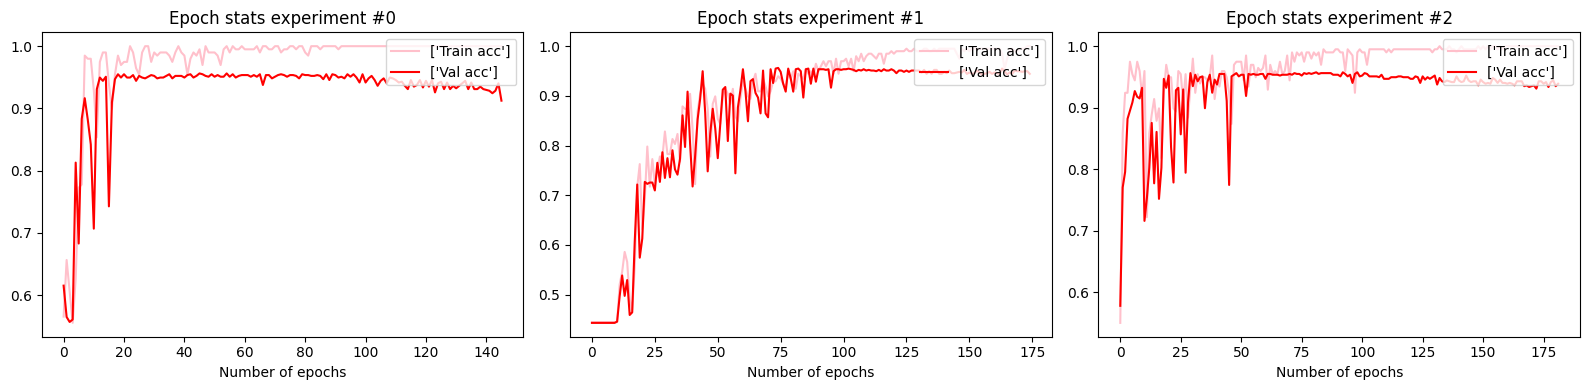

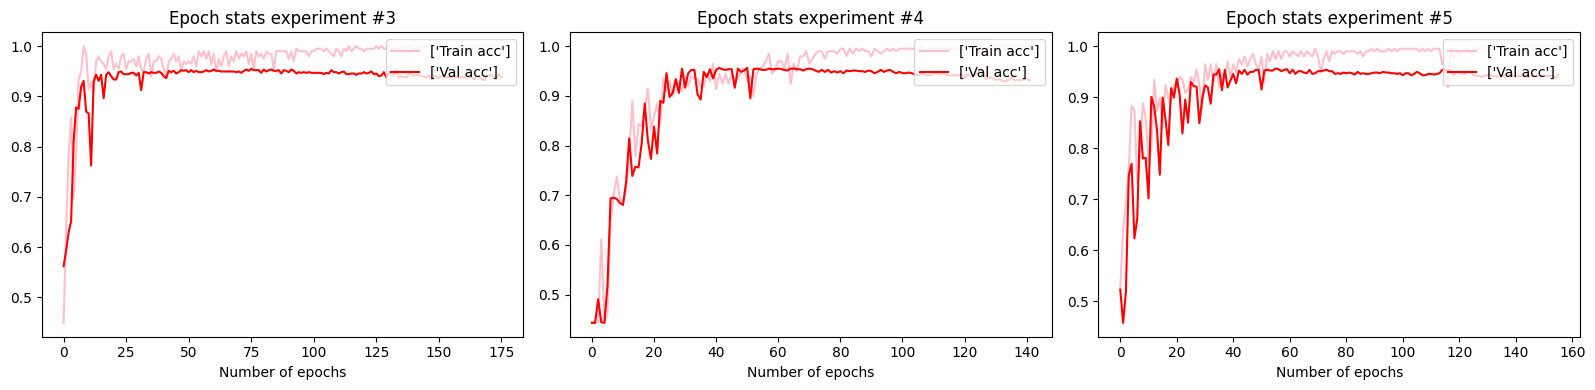

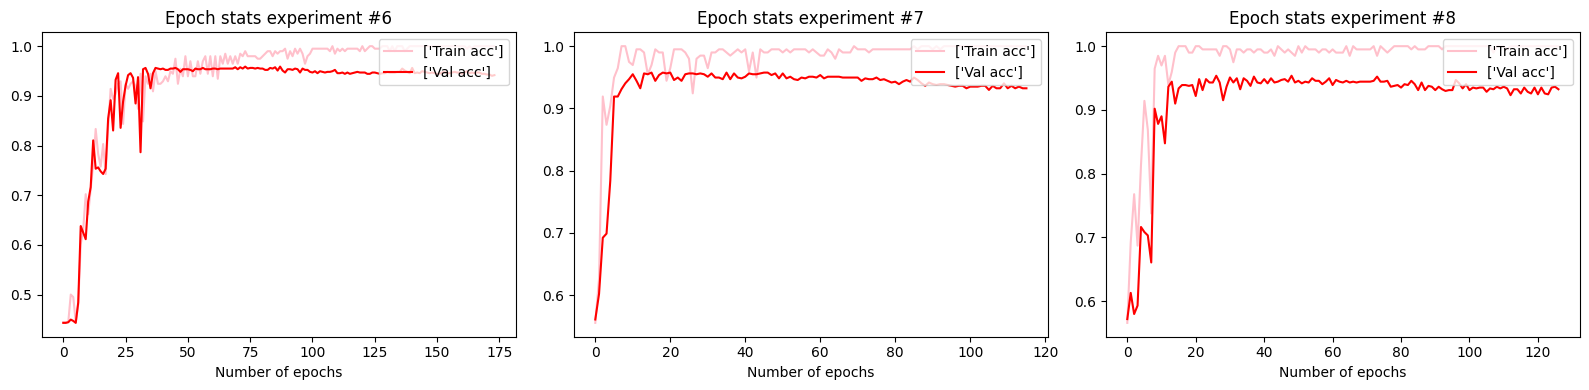

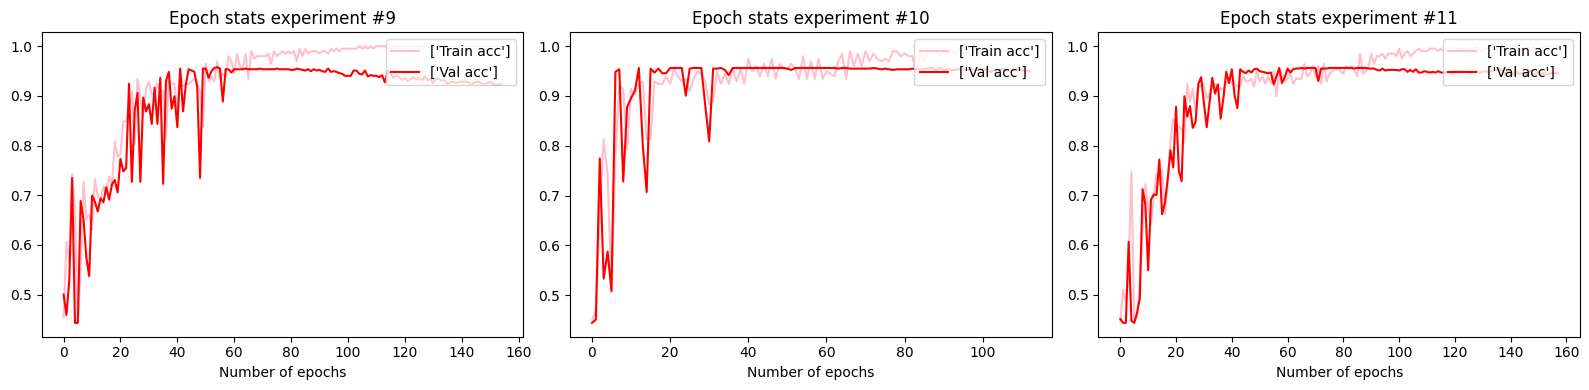

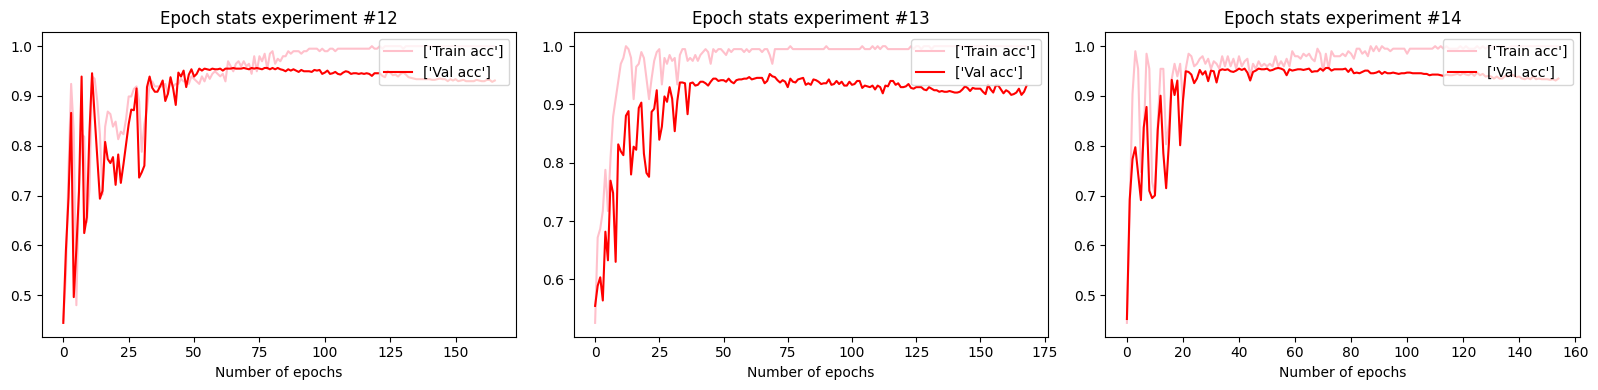

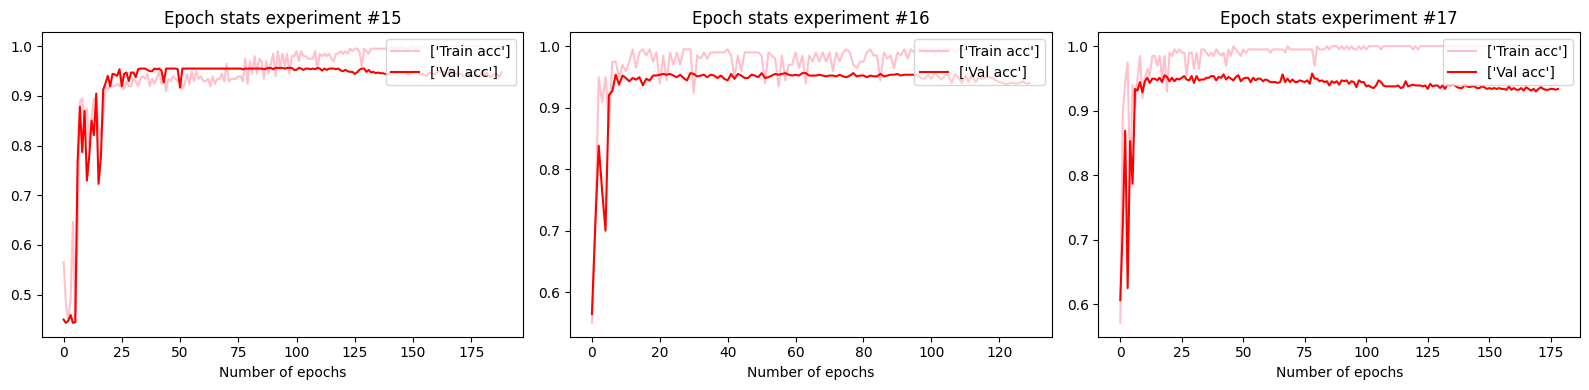

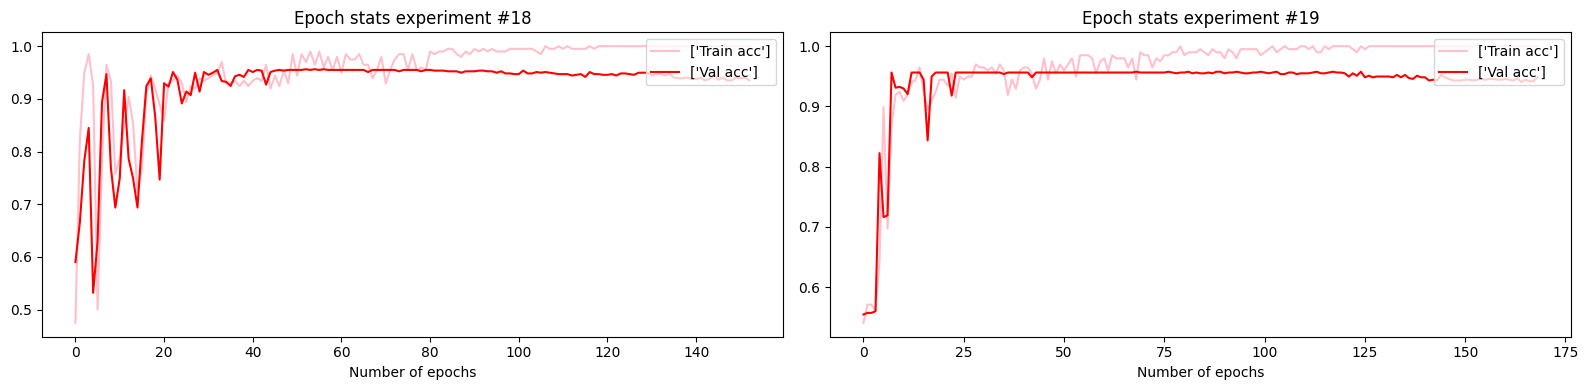

In [40]:
display_epochs_stats(cnn_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### LSTM

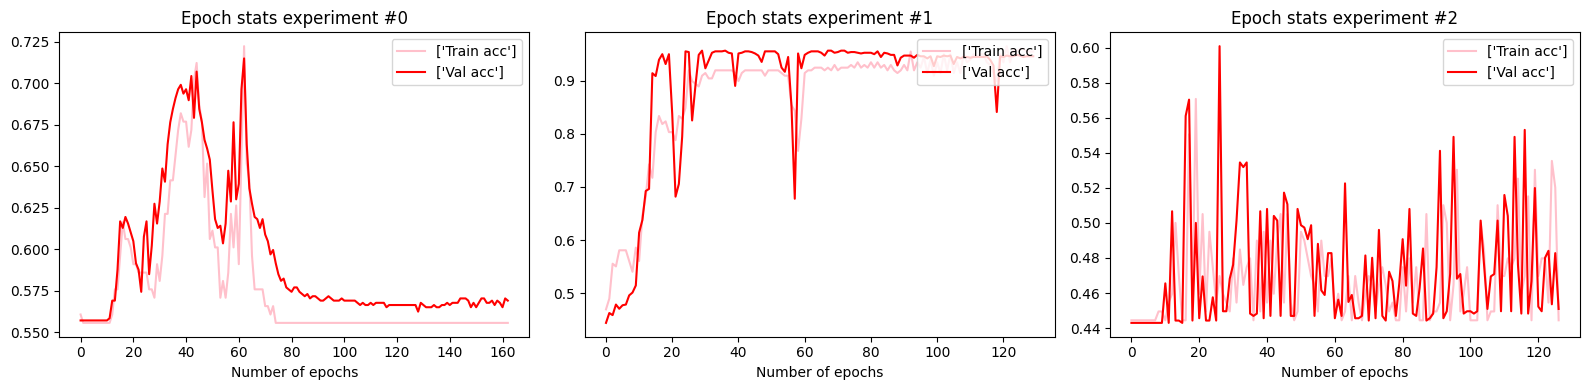

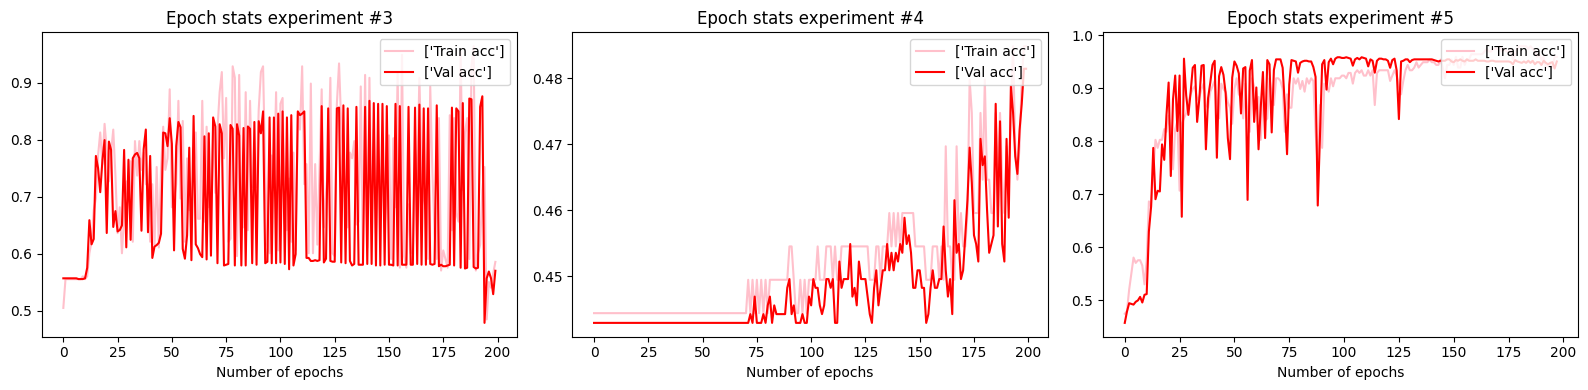

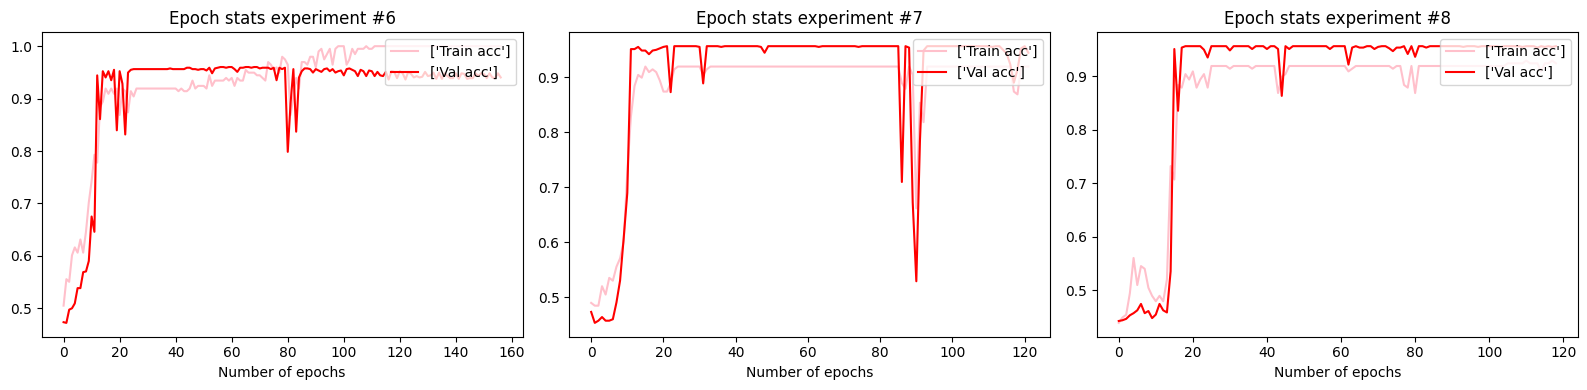

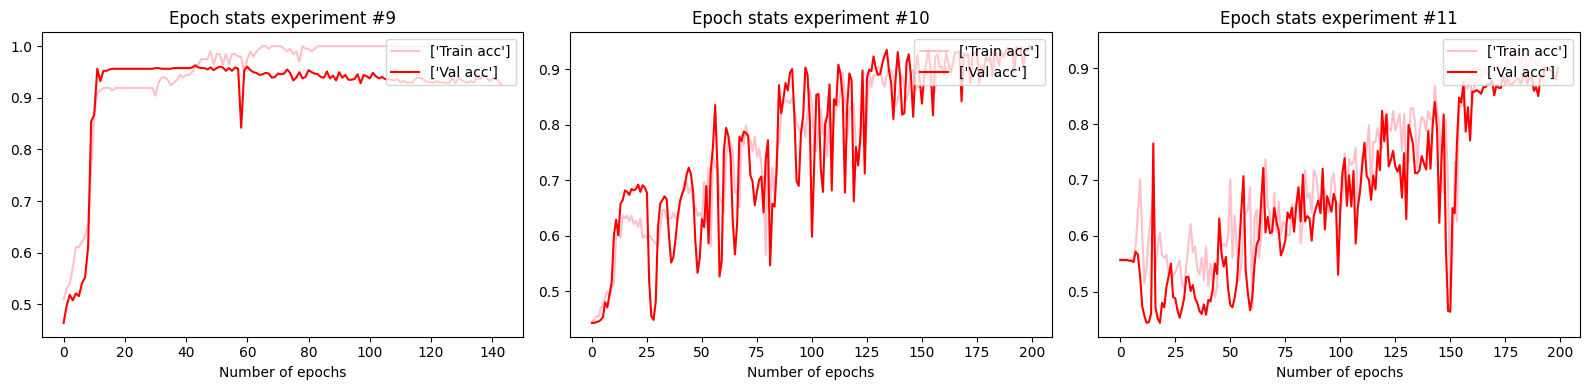

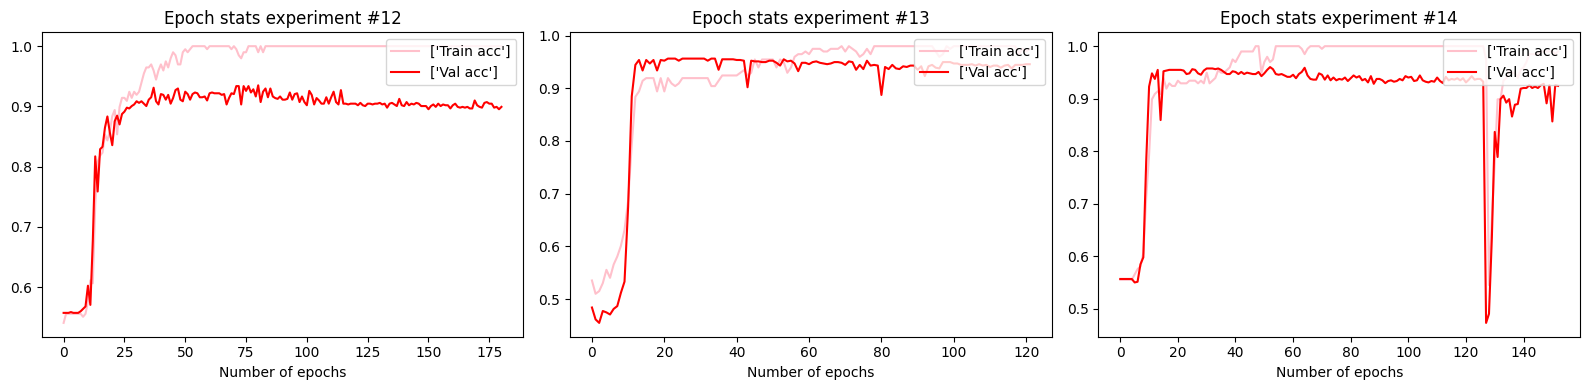

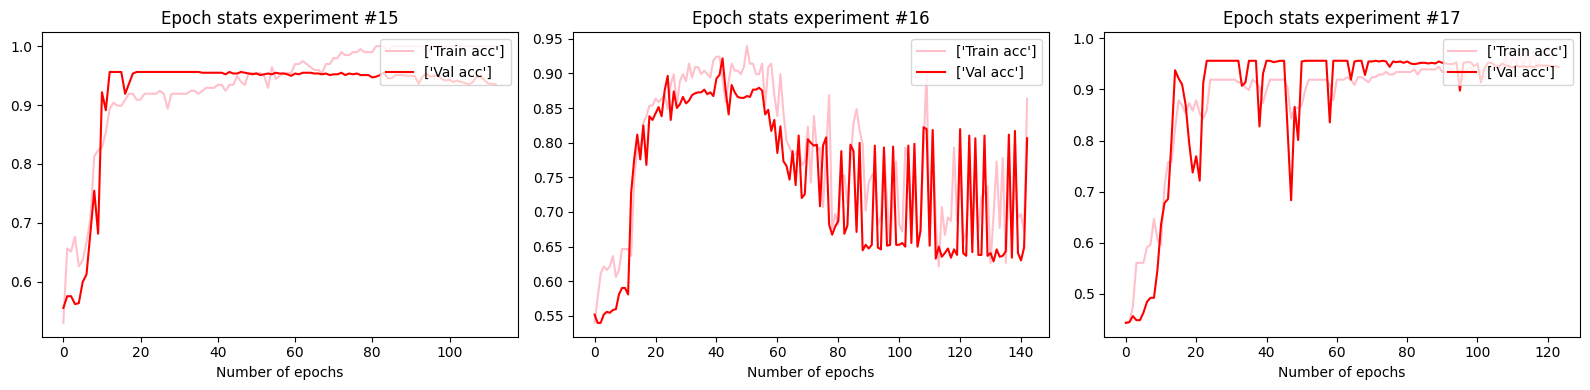

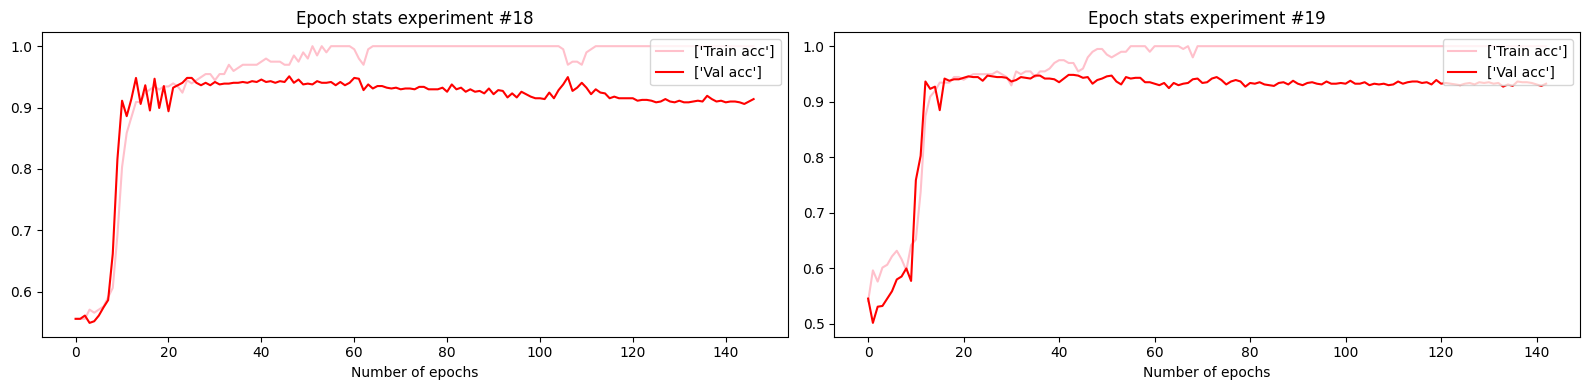

In [41]:
display_epochs_stats(lstm_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V1

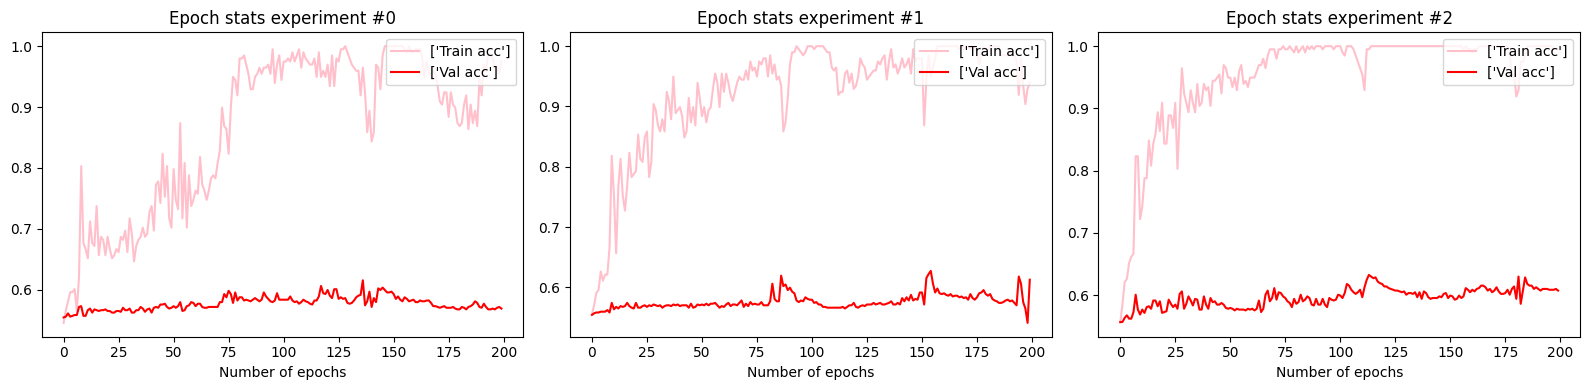

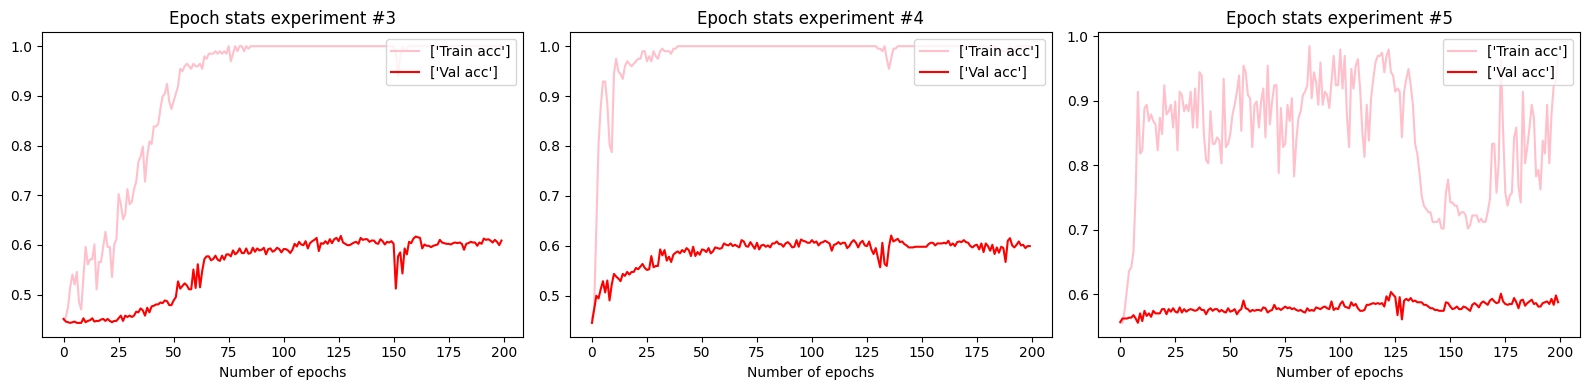

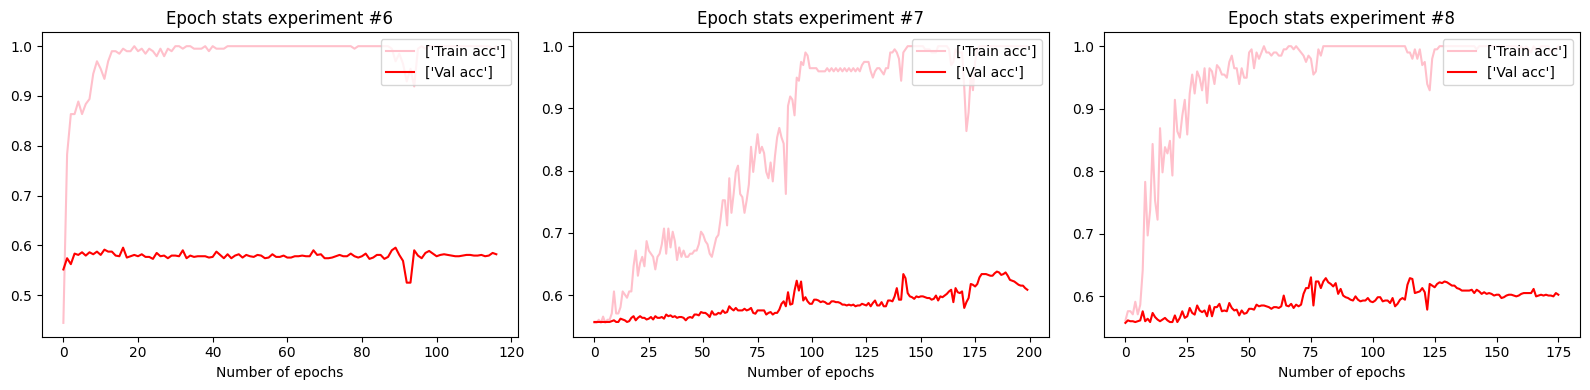

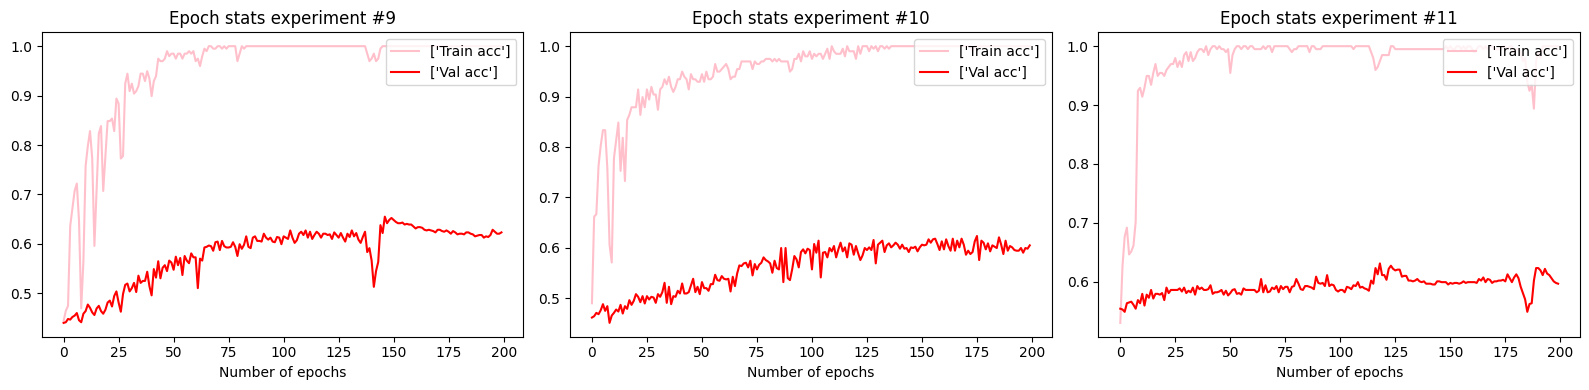

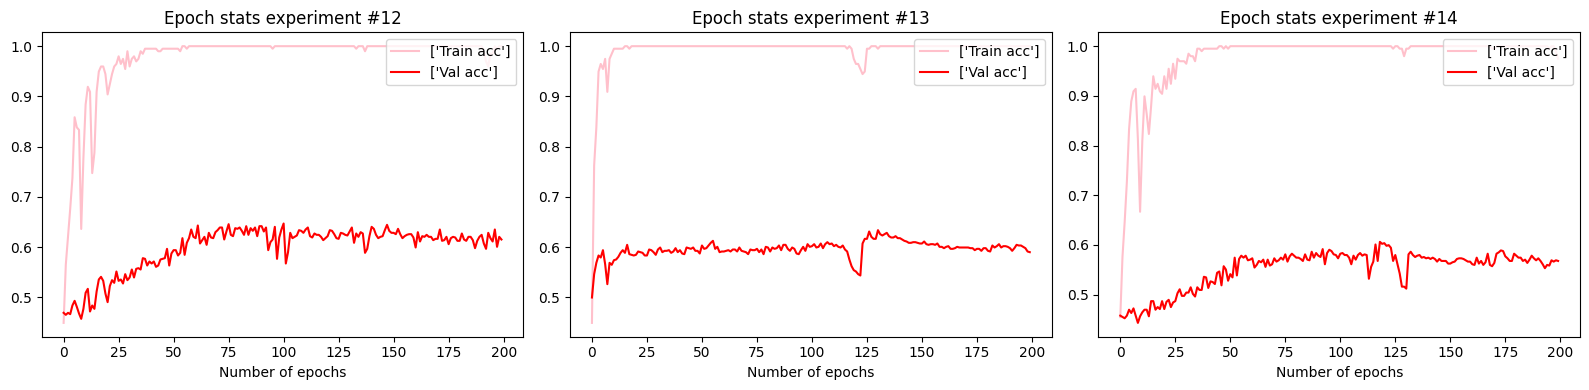

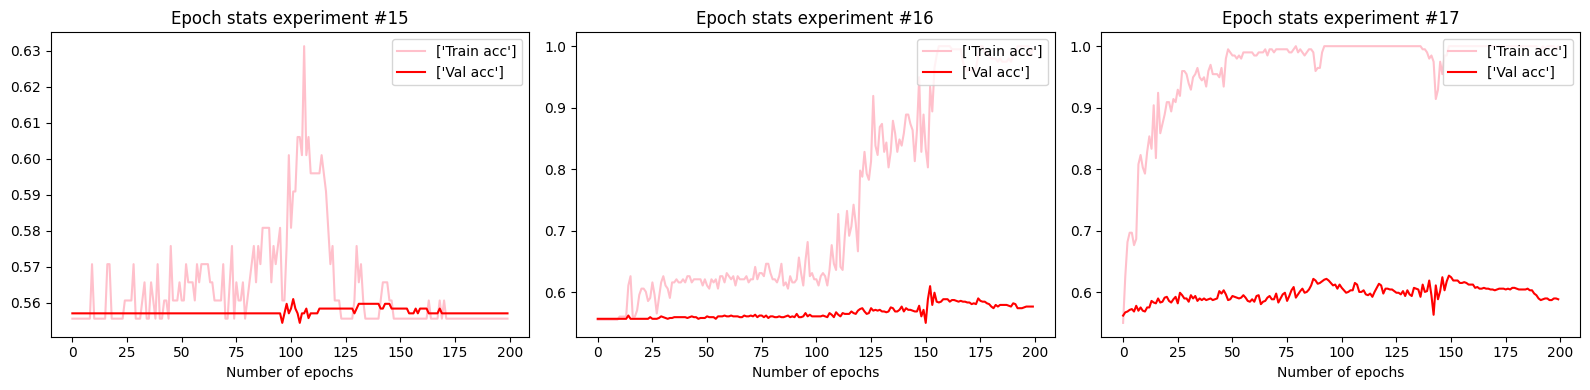

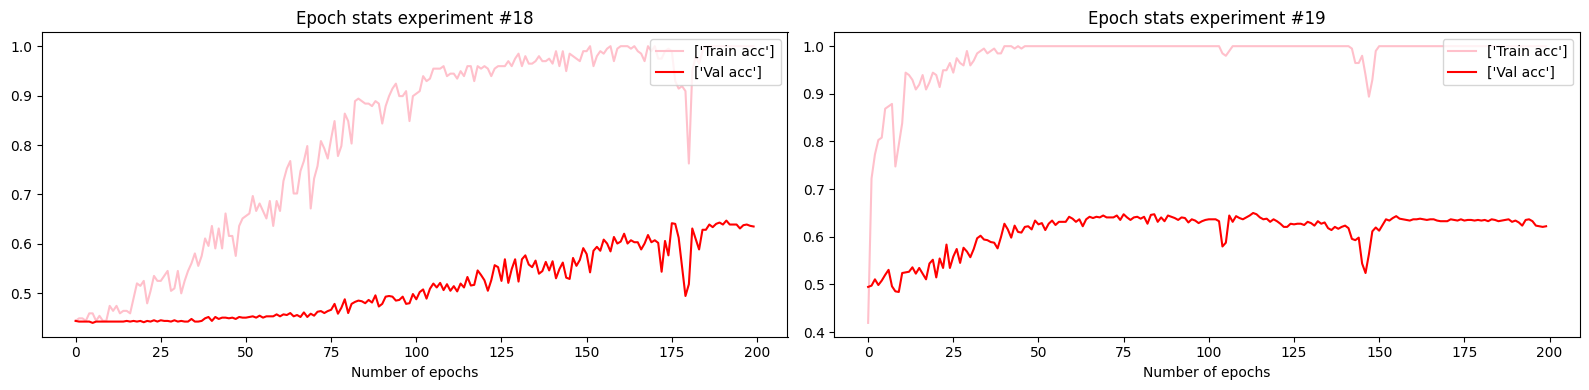

In [42]:
display_epochs_stats(deepset_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V2

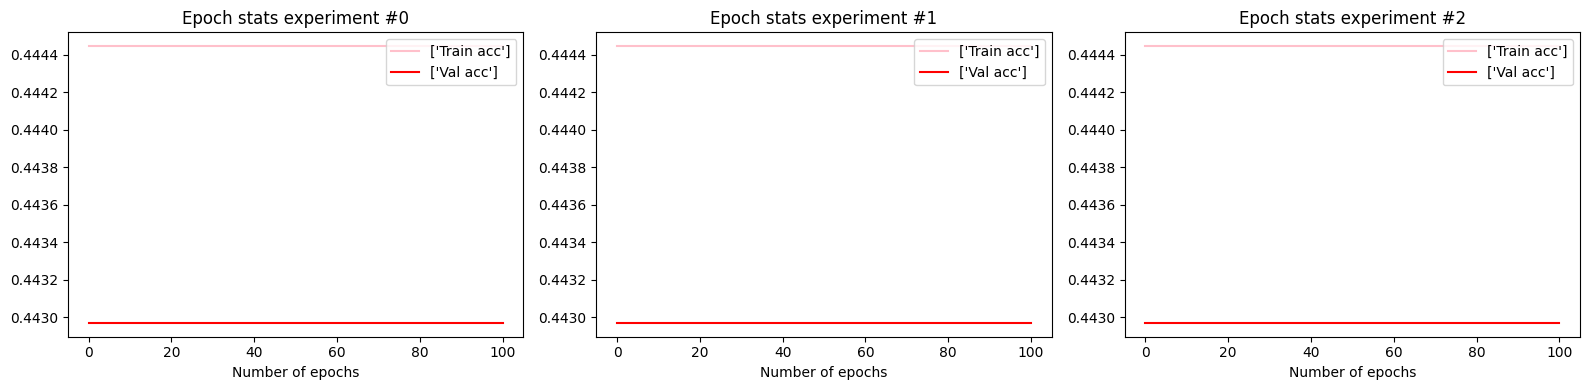

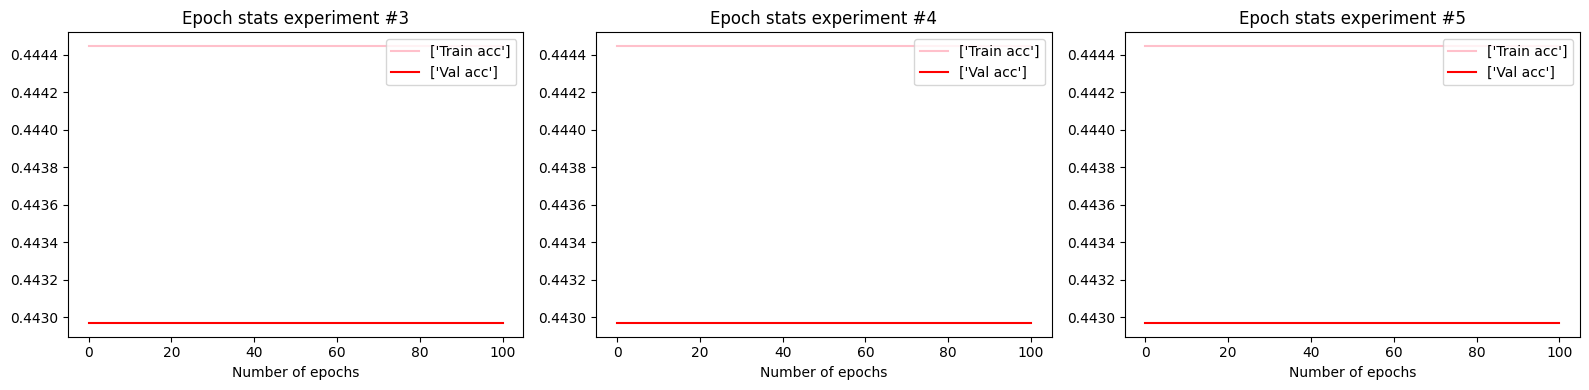

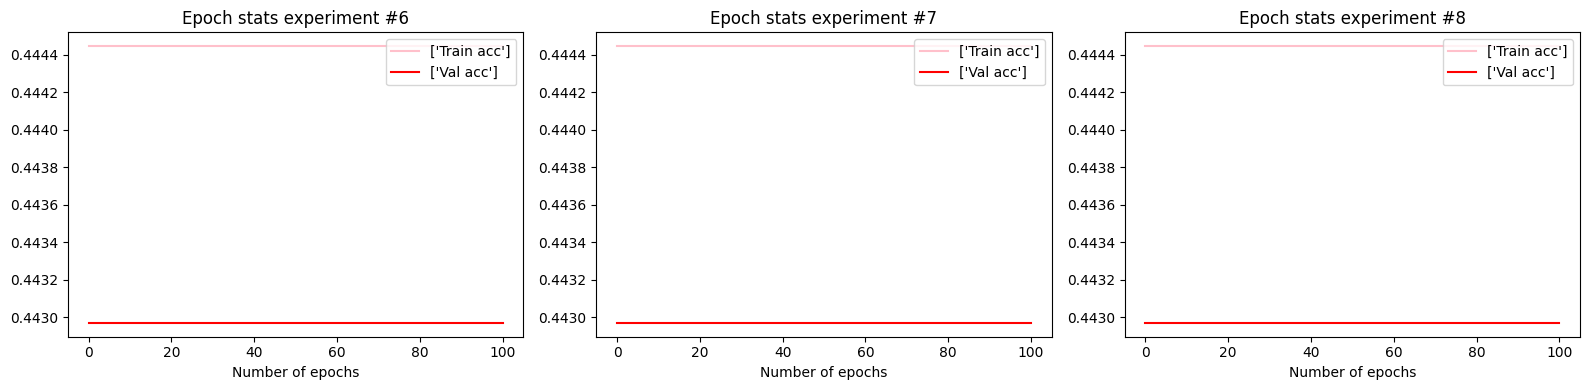

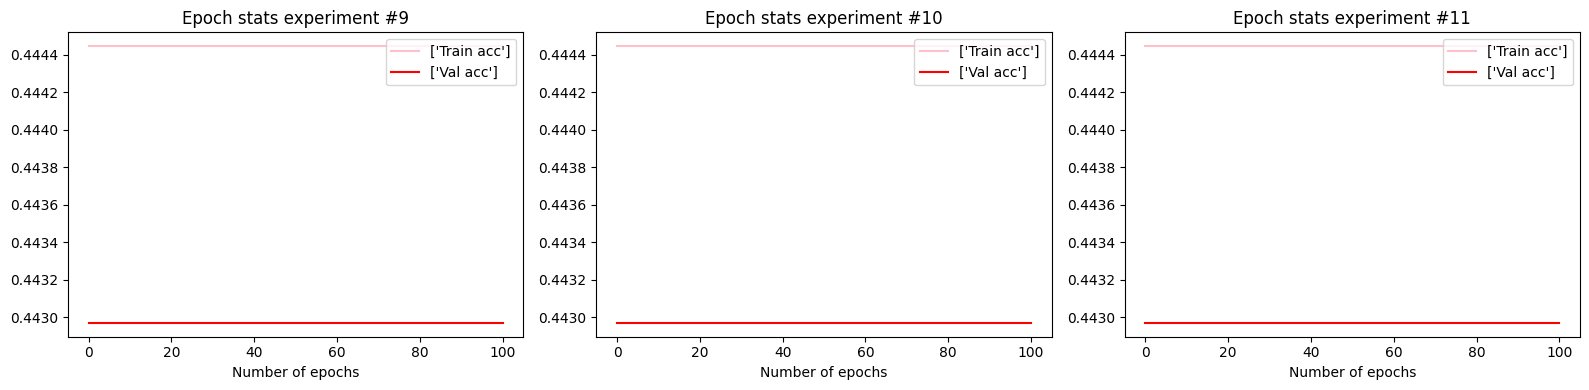

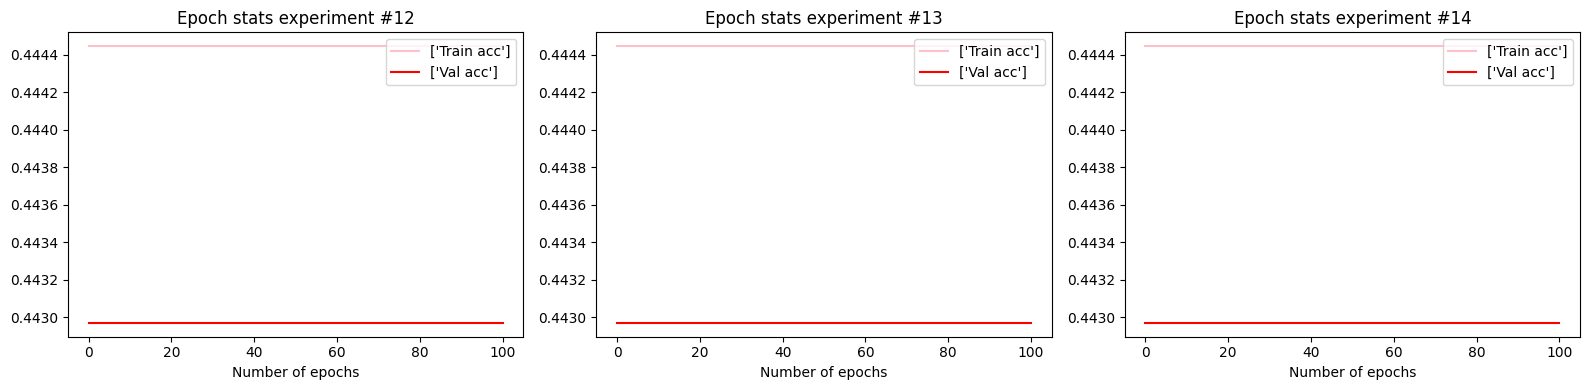

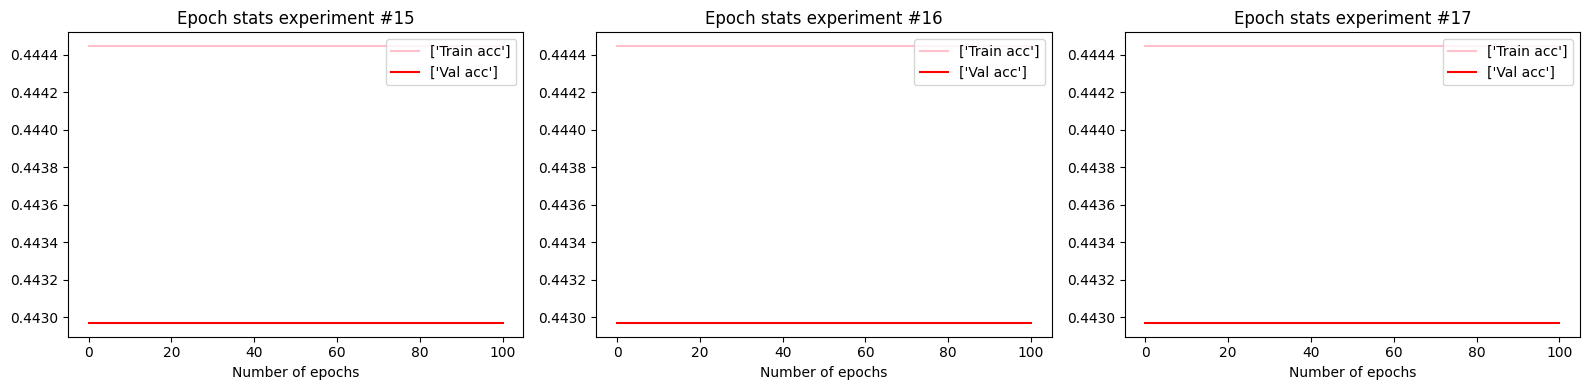

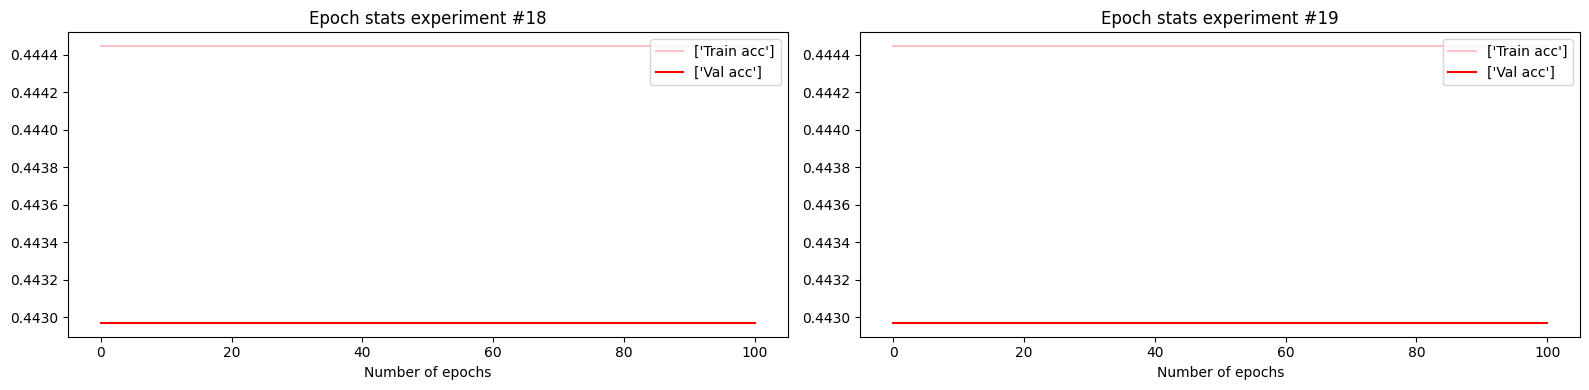

In [43]:
display_epochs_stats(deepsetv2_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### FeedForward

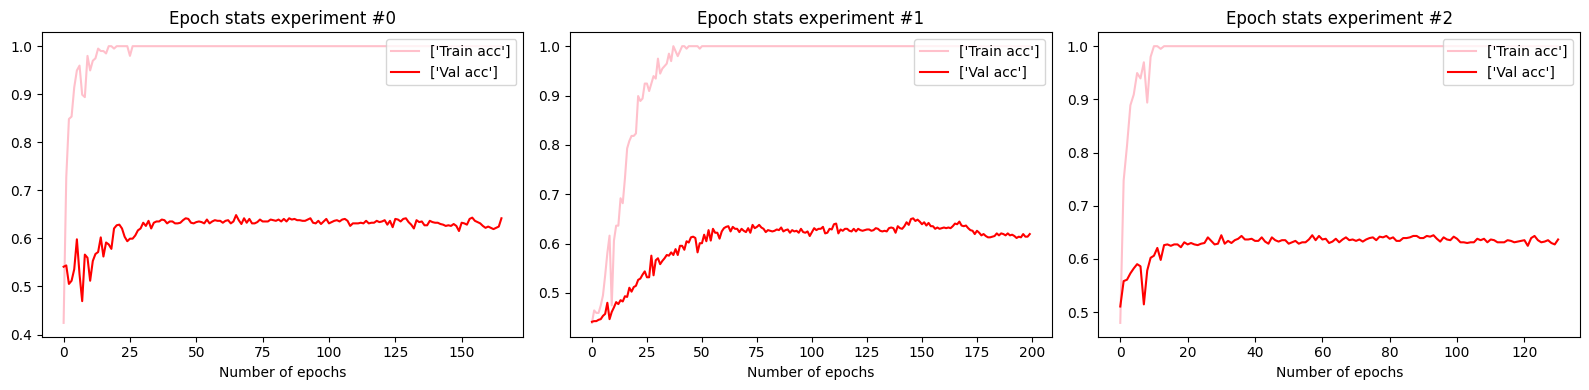

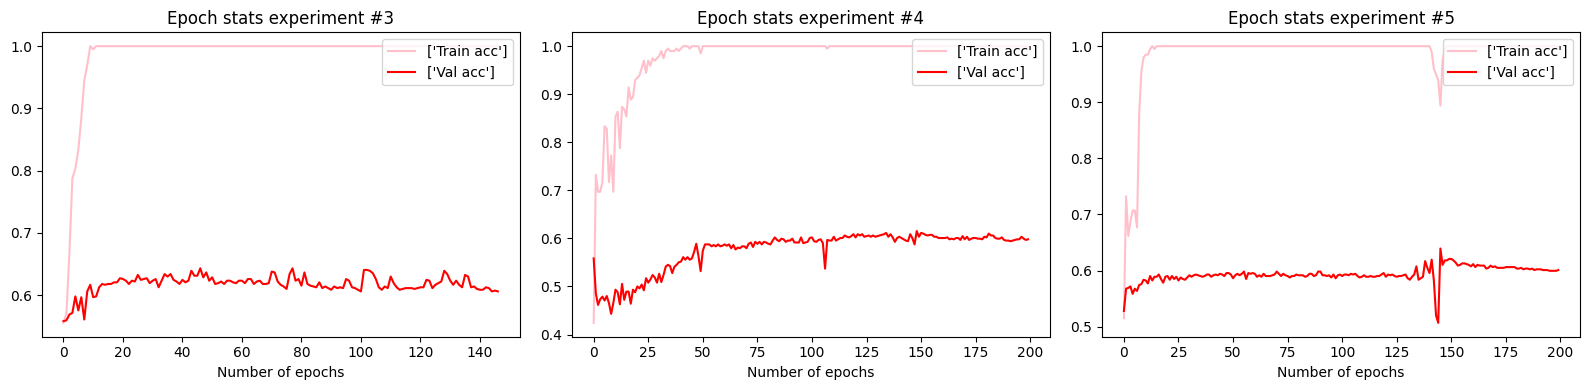

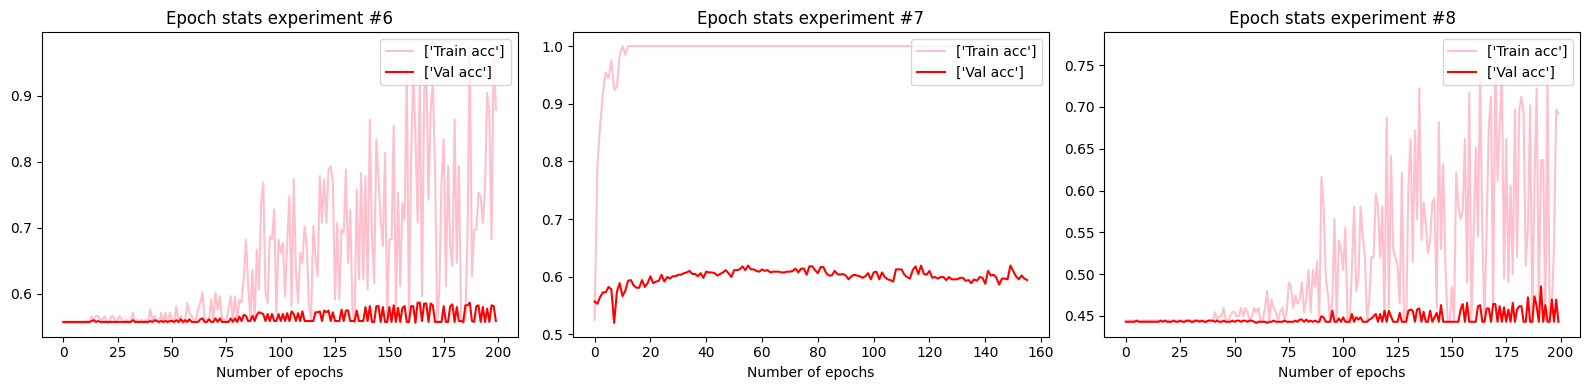

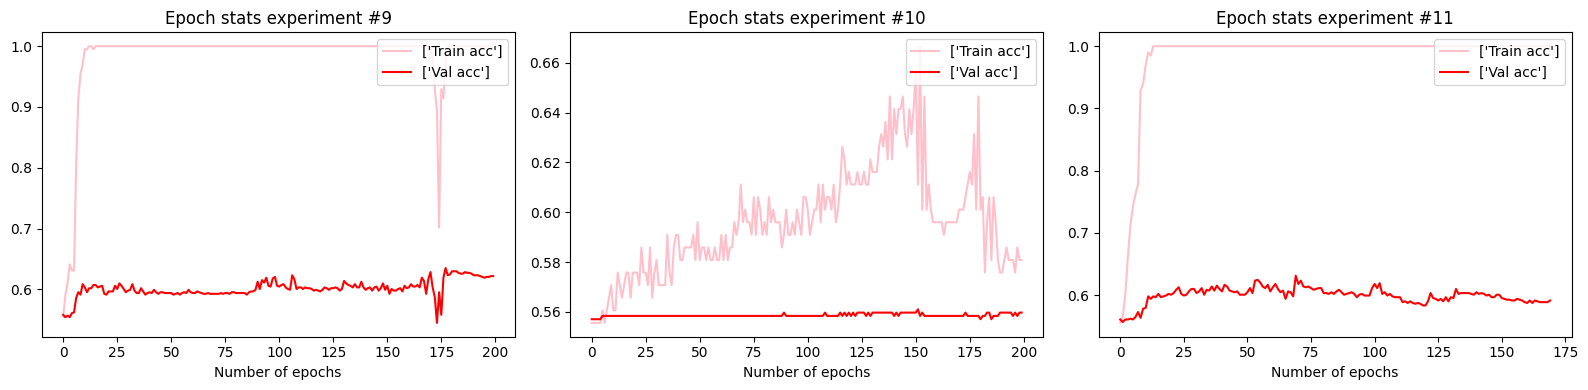

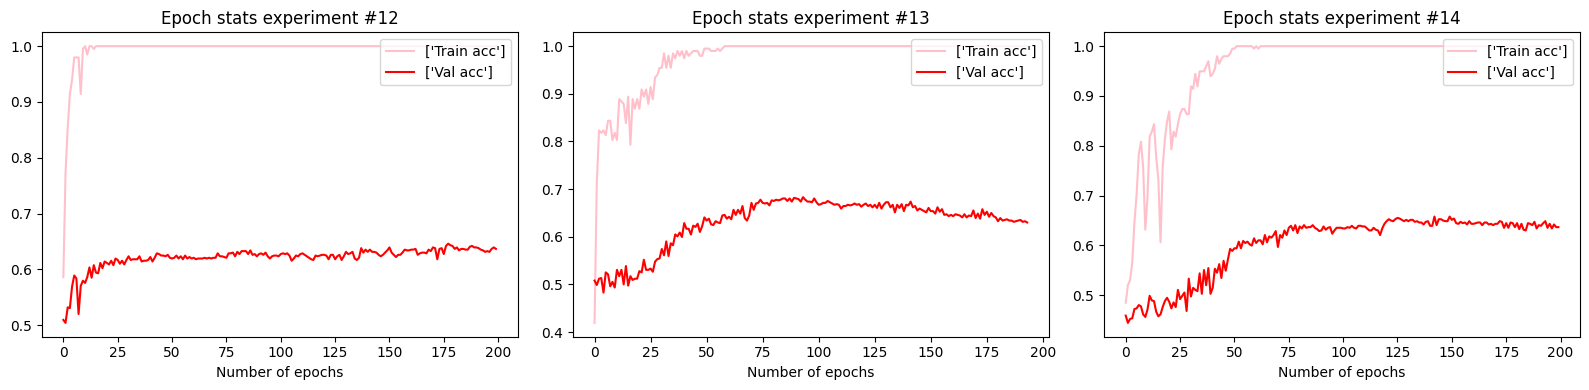

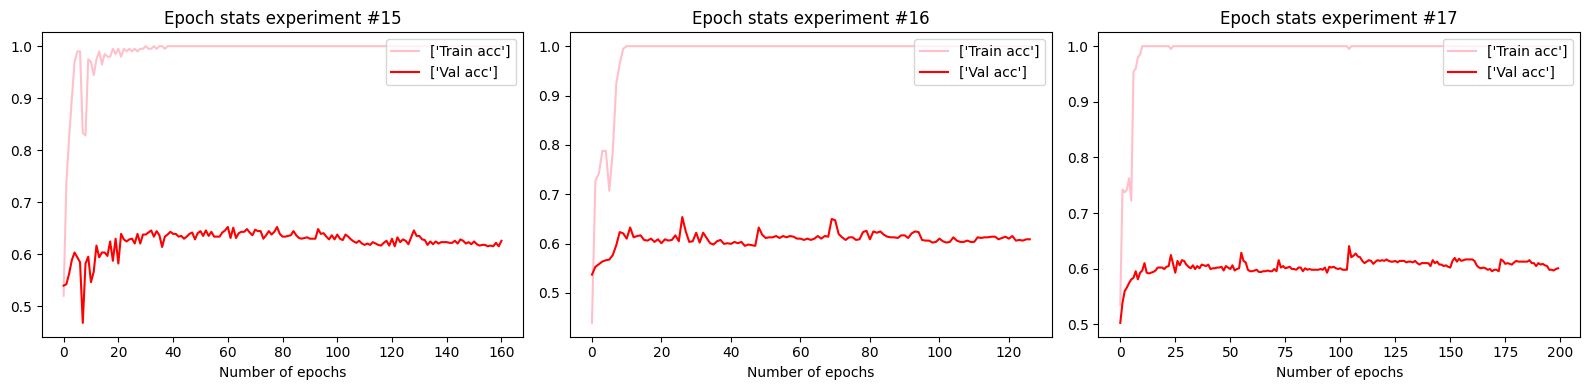

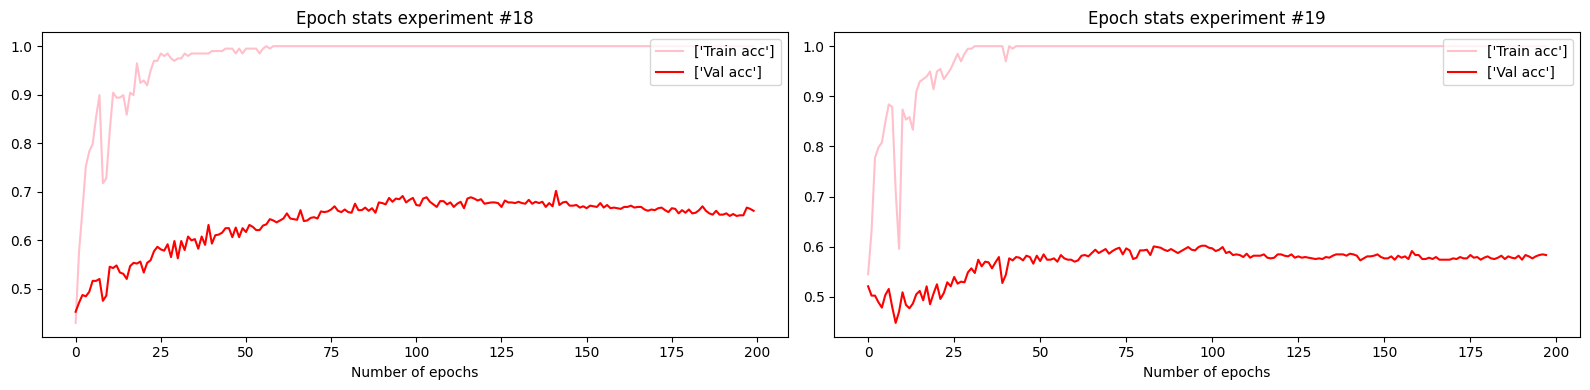

In [44]:
display_epochs_stats(feedforward_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

# Best performing models

In [46]:
best_lstm_model = LSTM_Model(data, 16, 32, 8).to(device)
best_lstm_model.load_state_dict(torch.load('./bestmodels/best_LSTM_model_5%'))
best_cnn_model = CNN_Model(data, 64, 128, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('./bestmodels/best_CNN_model_5%'))
best_deepset_model = DEEPSET_Model(data).to(device)
best_deepset_model.load_state_dict(torch.load('./bestmodels/best_DEEPSET_model_5%'))
best_deepsetv2_model = DEEPSETV2_Model(data).to(device)
best_deepsetv2_model.load_state_dict(torch.load('./bestmodels/best_DEEPSETV2_model_5%'))
best_feedforward_model = FEEDFORWARD_Model(data).to(device)
best_feedforward_model.load_state_dict(torch.load('./bestmodels/best_FEEDFORWARD_model_5%'))

C:\Users\franm\AppData\Local\Temp\ipykernel_21588\3872038394.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_lstm_model.load_state_dict(torch.load('best_LSTM_model_

<All keys matched successfully>

## Top wrong predictions for best performing CNN model

In [47]:
print_wrong_preds([get_wrong_predictions(best_cnn_model, x_test_cnn, y_test, test_original)], top_k=10)

Top 10 false positives: 

.,,_wu...,___,_, ,,...dr__.,..,_, | label: False | actual prediction: 0.8874130249023438
,_wu,.,_.,.,_,., ..dr_..__._.,.,_ | label: False | actual prediction: 0.879610538482666
_wu,_,_,_.,,,.._ _.,._,_,,.dr.,,. | label: False | actual prediction: 0.8790689706802368
._wu,,,,__,_.,., _,,._,_,.,,dr._, | label: False | actual prediction: 0.8772255778312683
_wu.__.,__,..___ ..dr,,_.,_,.,,__ | label: False | actual prediction: 0.8769986629486084
_,,.,.,.__wu_,__ _.,dr._,,.,...__ | label: False | actual prediction: 0.8734403252601624
._wu.,,.,____._, ..,.._dr.,_.._.. | label: False | actual prediction: 0.8734054565429688
,_wu_,__,,____,_ _.__,dr.,,,_,_., | label: False | actual prediction: 0.8653221726417542
,__,____._wu_.,_ _,_.,.,..dr_,,._ | label: False | actual prediction: 0.8584334254264832
,wu.__..,.__.,,, .,,dr.__._,__,,. | label: False | actual prediction: 0.8552172780036926

Top 10 false negatives: 

..._,,_,..__.wu. r_,,.,,....._,,, | label: True | actual p

## Top wrong predictions for best performing LSTM model

In [48]:
print_wrong_preds([get_wrong_predictions(best_lstm_model, x_test_lstm, y_test, test_original)], top_k=10)

Top 10 false positives: 

_,_wu,_,._,.,__. ,dr._,,,____,.._ | label: False | actual prediction: 0.8603805303573608
wu_.__,__.,_,._. .dr___.._,..,_._ | label: False | actual prediction: 0.8552133440971375
_,._,wu._,_,,_., .,..._dr.__...,_ | label: False | actual prediction: 0.8538258671760559
,._,_,..,wu__._, ..__,.,_._.dr_._ | label: False | actual prediction: 0.8527846336364746
_,__,_wu,_,._,_. ,..,___.__,.,_dr | label: False | actual prediction: 0.8518696427345276
_wu_.,.,_,_,,.__ ..,_,_,__.,.__dr | label: False | actual prediction: 0.8515304923057556
.wu,___._._.,,_. .,,_dr,.,,___.._ | label: False | actual prediction: 0.851513683795929
,__,____._wu_.,_ _,_.,.,..dr_,,._ | label: False | actual prediction: 0.8506137132644653
_,wu___,._._.,_. ._.,dr,_,___.... | label: False | actual prediction: 0.8473677635192871
_.,_wu.,,___,_., ._._._,._,,,..dr | label: False | actual prediction: 0.8470734357833862

Top 10 false negatives: 

,____.,...,uw... dr,,.._,,,_.___, | label: True | actual p

## Top wrong predictions for best performing DeepSets V1 model

In [49]:
print_wrong_preds([get_wrong_predictions(best_deepset_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

___,,.___,,_,_., ...,,,._,,.,..., | label: False | actual prediction: 0.9094273447990417
,,__,,__,_,,____ ,__,,,___,,_.___ | label: False | actual prediction: 0.9092919230461121
_wu....,,_.,,_., ,.,,___dr,.,._._ | label: False | actual prediction: 0.9083889722824097
,,.,_..__,..,,_w ,_,,..__.___,_._ | label: False | actual prediction: 0.908280074596405
_,,,,._,,._wu___ ._,,.,,_,,dr___. | label: False | actual prediction: 0.9054415225982666
.,,.,.,._,__,_,. __,,__.,__..cr,_ | label: False | actual prediction: 0.9027434587478638
,,.,wu__.__,___. _,,cr.,..,.,..,. | label: False | actual prediction: 0.9001821279525757
,,,_._._,,,_._,_ .,,,,,__,,.._cr_ | label: False | actual prediction: 0.8990105390548706
__,w_,,,_,,,_,_, ,_.,_.__,,__.,., | label: False | actual prediction: 0.8973662257194519
,,_.._,,_._,____ ._,_cr,_.,_...._ | label: False | actual prediction: 0.8905022740364075

Top 10 false negatives: 

__._..,,,._...., ..._.,_..___dr_. | label: True | actual p

## Top wrong predictions for best performing DeepSets V2 model

In [50]:
print_wrong_preds([get_wrong_predictions(best_deepsetv2_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 

,._wu.,.,,.__.,_ __._,,_..r.,,,., | label: True | actual prediction: 0.5
,...._...uw_,__, ._,r,_,.._,,_.,_ | label: True | actual prediction: 0.5
_.____.._,,.,.__ ..._..r,._,.,_,. | label: True | actual prediction: 0.5
_,_,_.,.__.w___. _,_,dr,__._..... | label: True | actual prediction: 0.5
wu__.,,,,,_._.._ ___r_..__,.,,_,. | label: True | actual prediction: 0.5
_._,,_..,,,_..,_ .r,_.____,._,... | label: True | actual prediction: 0.5
.,.__w_.,_.._,,_ ...,_.._r,_,._,. | label: True | actual prediction: 0.5
__..,,_..uw.,,,, r_.._._._.__.,.. | label: True | actual prediction: 0.5
...,..w,,,_.._._ ,,_,.,_.r_.._,., | label: True | actual prediction: 0.5
wu_,.._,___...._ _.r.._.._._,,... | label: True | actual prediction: 0.5




## Top wrong predictions for best performing Feedforward model

In [51]:
print_wrong_preds([get_wrong_predictions(best_feedforward_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

_,,,,._,,._wu___ ._,,.,,_,,dr___. | label: False | actual prediction: 0.9466654658317566
___,,.___,,_,_., ...,,,._,,.,..., | label: False | actual prediction: 0.935688853263855
,,,,,.,.w_,.,.,. ._.._,,__,..,_,. | label: False | actual prediction: 0.929446816444397
,.,uw___.___..._ ,._._.__,,.._.., | label: False | actual prediction: 0.9294425845146179
.._,.wu._,._,___ _,._..,,,dr...__ | label: False | actual prediction: 0.9243848919868469
,_wu,.,_.,.,_,., ..dr_..__._.,.,_ | label: False | actual prediction: 0.9230748414993286
,.,.,,__.,__uw__ ,.,._,_.,_.,._,_ | label: False | actual prediction: 0.9216299057006836
...,,.,_.,wu,_._ ,,dr....,__...,, | label: False | actual prediction: 0.919882595539093
_.,,,,._,__,____ ._,,,..,...,,... | label: False | actual prediction: 0.9132662415504456
.,,,.,uw,,,,.__. ,,..cr____,_.,__ | label: False | actual prediction: 0.9129382371902466

Top 10 false negatives: 

.,___,__,,_._,,, ,....,,,.,,,dr_. | label: True | actual pre

# Saving Notebook State

In [ ]:
import dill
# dill.dump_session('notebook_env_5per.db')

# Loading Notebook State

In [ ]:
import dill
dill.load_session('notebook_env_5per.db')